# 🧮 Naive Bayes — Overview
## ✨ What this notebook covers
- Intuition & probabilistic motivation  
- Bayes' rule and the *naive* (conditional independence) assumption  
- Common variants: **Gaussian**, **Multinomial**, **Bernoulli**  
- Mathematical formulas & decision rule (with equations)  
- Laplace / add-1 smoothing for discrete features  
- `scikit-learn` usage for each variant ✅  
- From-scratch implementations (educational) ✅  
- Visual examples (continuous & text) and step-by-step explanation 🚀


In [1]:
# Imports & defaults
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
np.random.seed(0)


## 📐 Intuition: What is Naive Bayes?

Naive Bayes is a family of **probabilistic classifiers** based on **Bayes' Theorem**.  
It predicts the class with the **highest posterior probability** $ P(y \mid \mathbf{x}) $.

---

### 🔸 Bayes' Theorem
$$
P(y \mid \mathbf{x}) = \frac{P(y)\, P(\mathbf{x} \mid y)}{P(\mathbf{x})}
$$

---

### 🔸 Naive Conditional Independence Assumption  
Assume features $x_1, x_2, \ldots, x_d$ are **conditionally independent** given the class $y$:

$$
P(\mathbf{x} \mid y) = \prod_{i=1}^d P(x_i \mid y)
$$

---

### 🔸 Decision Rule (MAP — Maximum A Posteriori)
$$
\hat{y} = \arg\max_y\; P(y)\prod_{i=1}^d P(x_i\mid y)
$$

Since $P(\mathbf{x})$ is constant across classes, it is ignored in the **argmax**.

---

### 🔸 Log Form (for Numerical Stability)
$$
\hat{y} = \arg\max_y\; \log P(y) + \sum_{i=1}^d \log P(x_i \mid y)
$$

Using logs avoids underflow when multiplying many small probabilities.

---


## 🧾 Variants & when to use them

- **GaussianNB** — for continuous features (assumes $x_i\mid y \sim \mathcal{N}(\mu_{iy}, \sigma_{iy}^2)$).  
- **MultinomialNB** — for count features (e.g., word counts in text). Models $P(\text{word}_i\mid y)$.  
- **BernoulliNB** — for binary features (presence/absence; e.g., word occurs or not).  
- **Smoothing (Laplace/add-α)** — avoids zero probabilities for unseen feature values in training.


## 🧮 Gaussian Naive Bayes — Math (feature-wise normality)

Assume each feature $x_i \mid y$ is Gaussian:

$$
P(x_i \mid y=k) = \frac{1}{\sqrt{2\pi\sigma_{ik}^2}} \exp\left(-\frac{(x_i-\mu_{ik})^2}{2\sigma_{ik}^2}\right)
$$

Log-posterior (up to additive constant):

$$
\log P(y=k \mid \mathbf{x}) \propto \log P(y=k) - \frac{1}{2}\sum_{i}\left[\log(2\pi\sigma_{ik}^2) + \frac{(x_i-\mu_{ik})^2}{\sigma_{ik}^2}\right]
$$


In [2]:
# Simple synthetic example (GaussianNB)
X, y = make_classification(n_samples=400, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, class_sep=1.2, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train_s, y_train)
print("GaussianNB train acc:", gnb.score(X_train_s, y_train))
print("GaussianNB test acc:", gnb.score(X_test_s, y_test))


GaussianNB train acc: 0.9357142857142857
GaussianNB test acc: 0.9666666666666667


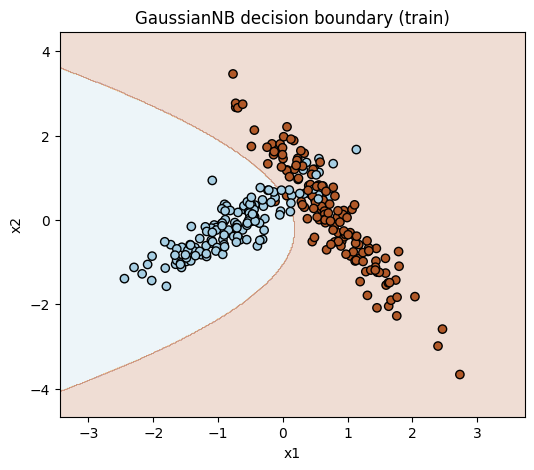

In [3]:
# Plot decision surface for GaussianNB
def plot_nb_decision_boundary(model, X, y, title='Decision boundary'):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,400), np.linspace(y_min,y_max,400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.2, cmap='Paired')
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', cmap='Paired')
    plt.title(title); plt.xlabel('x1'); plt.ylabel('x2')
    plt.show()

plot_nb_decision_boundary(gnb, X_train_s, y_train, title='GaussianNB decision boundary (train)')


## 🔁 GaussianNB — step-by-step training algorithm

1. For each class $k$:
   - Estimate prior: $$ \hat{P}(y=k) = \dfrac{N_k}{N} $$
   - For each feature $i$: estimate mean $\mu_{ik}$ and variance $\sigma_{ik}^2$ using training examples in class $k$.

2. To predict for a sample $\mathbf{x}$:
   - Compute log posterior for each class using Gaussian density (see formula above).
   - Predict class with highest log posterior.


## 🧮 Multinomial Naive Bayes — Math (counts, useful for text)

For discrete count features (e.g., word counts), likelihood of word counts given class $k$:

$$
P(\mathbf{x}\mid y=k) = \frac{(\sum_i x_i)!}{\prod_i x_i!} \prod_i p_{ik}^{x_i}
$$

Ignoring multinomial coefficient (constant for a given $\mathbf{x}$), log-likelihood becomes:

$$
\log P(y=k\mid\mathbf{x}) \propto \log P(y=k) + \sum_i x_i \log p_{ik}
$$

Where $p_{ik} = P(\text{feature } i \mid y=k)$ estimated as:

$$
\hat{p}_{ik} = \frac{N_{ik} + \alpha}{\sum_j N_{jk} + \alpha V}
$$

- $N_{ik}$ = total count of feature $i$ in class $k$  
- $V$ = number of features (vocabulary size)  
- $\alpha$ = smoothing parameter (Laplace when $\alpha=1$)


In [4]:
# Text example: MultinomialNB using 20 newsgroups (subset) — quick demo
cats = ['alt.atheism', 'sci.space']
news = fetch_20newsgroups(subset='train', categories=cats, remove=('headers','footers','quotes'))
X_text, y_text = news.data, news.target

vect = CountVectorizer(stop_words='english', max_features=2000)
X_counts = vect.fit_transform(X_text)
X_tr, X_val, y_tr, y_val = train_test_split(X_counts, y_text, test_size=0.3, random_state=2)

mnb = MultinomialNB(alpha=1.0)
mnb.fit(X_tr, y_tr)
print("MultinomialNB train acc:", mnb.score(X_tr, y_tr))
print("MultinomialNB val acc:", mnb.score(X_val, y_val))


MultinomialNB train acc: 0.9387483355525965
MultinomialNB val acc: 0.8944099378881988


In [5]:
# Example: inspect top words for each class (by log prob)
feature_names = np.array(vect.get_feature_names_out())
class0_top = np.argsort(mnb.feature_log_prob_[0])[-15:]
class1_top = np.argsort(mnb.feature_log_prob_[1])[-15:]
print("Top words class 0:", feature_names[class0_top])
print("Top words class 1:", feature_names[class1_top])


Top words class 0: ['religion' 'believe' 'true' 'say' 'know' 'like' 'atheism' 'argument'
 'does' 'just' 'jesus' 'think' 'don' 'people' 'god']
Top words class 1: ['people' 'new' 'satellite' 'moon' 'mission' 'launch' 'just' 'orbit'
 'data' 'time' 'shuttle' 'like' 'earth' 'nasa' 'space']


## 🧭 MultinomialNB — step-by-step (training & predict)

Training:
1. Compute class priors $ \hat{P}(y=k) = N_k / N $.
2. For each class $k$, sum counts $N_{ik}$ for each feature $i$.
3. Apply smoothing:  
   $$ \hat{p}_{ik} = \dfrac{N_{ik} + \alpha}{\sum_j N_{jk} + \alpha V} $$

Prediction:
1. Compute log-score for each class:  
   $$ \log P(y=k) + \sum_i x_i \log \hat{p}_{ik} $$
2. Pick class with max score.


## 🧪 BernoulliNB (binary features)

- Models binary-valued features $x_i \in \{0,1\}$ (feature present or absent).
- Likelihood per feature: $p_{ik}^{x_i}(1-p_{ik})^{1-x_i}$.
- Good for tasks where presence/absence matters more than counts.


In [6]:
# Quick BernoulliNB demo using binary word presence
vect_bin = CountVectorizer(binary=True, stop_words='english', max_features=2000)
X_bin = vect_bin.fit_transform(X_text)
X_trb, X_vb, y_trb, y_vb = train_test_split(X_bin, y_text, test_size=0.3, random_state=2)
bnb = BernoulliNB(alpha=1.0)
bnb.fit(X_trb, y_trb)
print("BernoulliNB val acc:", bnb.score(X_vb, y_vb))


BernoulliNB val acc: 0.8881987577639752


## 🛠️ From-scratch MultinomialNB (educational)
We'll implement a simple MultinomialNB that:
- Accepts sparse/dense count matrix X (n_samples x n_features)
- Uses Laplace smoothing (alpha)
- Computes log probabilities for prediction


In [7]:
# From-scratch MultinomialNB
class MultinomialNBFromScratch:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        # X: array-like or sparse matrix (n_samples, n_features)
        if hasattr(X, "toarray"):
            X = X.toarray()
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        self.class_count_ = np.zeros(n_classes, dtype=np.float64)
        self.feature_count_ = np.zeros((n_classes, n_features), dtype=np.float64)

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.class_count_[idx] = X_c.shape[0]
            self.feature_count_[idx, :] = X_c.sum(axis=0)

        # class priors (log)
        self.class_log_prior_ = np.log(self.class_count_ / n_samples)

        # smoothed feature log probabilities
        smoothed_fc = self.feature_count_ + self.alpha
        smoothed_denom = smoothed_fc.sum(axis=1)[:, np.newaxis]
        self.feature_log_prob_ = np.log(smoothed_fc / smoothed_denom)

    def predict_log_proba(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        # log P(y) + X @ feature_log_prob_.T
        return self.class_log_prior_ + X.dot(self.feature_log_prob_.T)

    def predict(self, X):
        log_probs = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_probs, axis=1)]


In [8]:
# Test from-scratch on the earlier CountVectorizer subset
mnb_scratch = MultinomialNBFromScratch(alpha=1.0)
mnb_scratch.fit(X_tr, y_tr)
y_pred_scratch = mnb_scratch.predict(X_val)
print("From-scratch MultinomialNB val acc:", accuracy_score(y_val, y_pred_scratch))


From-scratch MultinomialNB val acc: 0.8944099378881988


## ⚠️ Practical tips & diagnostics

- **Feature scaling** is usually *not required* for Multinomial/Bernoulli NB (features are counts or binary). For GaussianNB, scale features if they differ in magnitude.  

- **Smoothing ($\alpha$)**: if $\alpha=0$, unseen features lead to zero probability; use $\alpha=1$ (Laplace) or tune via validation.  

- **Calibrated probabilities**: Naive Bayes often gives poor probability estimates (well-calibrated for ranking but may be overconfident); use `CalibratedClassifierCV` if you need calibrated probabilities.  

- **When it works well**: text classification, spam detection, quick baselines — especially with many features and approximate conditional independence.  

- **When it fails**: when features are strongly correlated and assumption badly violated — but sometimes still performs well.


## ✅ Summary & next steps
- You learned:
  - Bayes' rule + naive independence → efficient classifier.
  - GaussianNB for continuous features; Multinomial/Bernoulli for discrete/text features.
  - Smoothing to handle zero counts, decision rule in log-space, and from-scratch educational implementations.
- Next suggestions I can add on request:
  - Cross-validation + hyperparameter tuning (alpha) example,
  - Calibrating probabilities,
  - Real-world pipeline: text preprocessing, n-grams, stopword handling, and comparison vs logistic regression.
  
Would you like a tuned pipeline for a full dataset (with grid search) or a runnable notebook file (.ipynb) generated from these cells? ✨
